#  Homework 5 Solutions - Berkeley STAT 157

**Your name: XX, SID YY** (Please add your name, and SID to ease Ryan and Rachel to grade.)

**Please submit your homework through [gradescope](http://gradescope.com/) instead of Github, so you will get the score distribution for each question. Please enroll in the [class](https://www.gradescope.com/courses/42432) by the Entry code: MXG5G5** 

Handout 2/19/2019, due 2/26/2019 by 4pm in Git by committing to your repository.

In this homework, we will model covariate shift and attempt to fix it using logistic regression. This is a fairly realistic scenario for data scientists. To keep things well under control and understandable we will use [Fashion-MNIST](http://d2l.ai/chapter_linear-networks/fashion-mnist.html) as the data to experiment on. 

Follow the instructions from the Fashion MNIST notebook to get the data.

In [15]:
%matplotlib inline
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test = gdata.vision.FashionMNIST(train=False)

## 1. Logistic Regression

1. Implement the logistic loss function $l(y,f) = -\log(1 + \exp(-y f))$ in Gluon.
2. Plot its values and its derivative for $y = 1$ and $f \in [-5, 5]$, using automatic differentiation in Gluon.
3. Generate training and test datasets for a binary classification problem using Fashion-MNIST with class $1$ being a combination of `sneaker` and `pullover` and class $-1$ being the combination of `sandal` and `shirt` categories. 
4. Train a binary classifier of your choice (it can be linear or a simple MLP such as from a previous lecture) using half the data (i.e. $12,000$ observations mixed as abvove) and one using the full dataset (i.e. $24,000$ observations as arising from the 4 categories) and report its accuracy. 

Hint - you should encapsulate the training and reporting code in a callable function since you'll need it quite a bit in the following. 

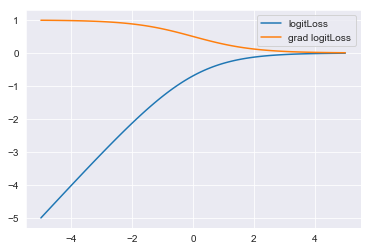

======== training with full dataset =========
Test Loss: 0.2894197, Test Accuracy: 0.8885
======== training with half dataset =========
Test Loss: 0.3132914, Test Accuracy: 0.88


In [87]:
### Part 1 ###

def logitLoss(y, f):
    return -nd.log(1. + nd.exp(-nd.dot(y,f)))

### Part 2 ###

x = np.linspace(-5,5,100)
f = nd.array(x)
y = nd.array([[1,],]) 
f.attach_grad()

with autograd.record():
    l = logitLoss(y, f.reshape(1,100))
    l.backward()

plt.plot(x, logitLoss(y, f.reshape(1,100))[0].asnumpy(), label='logitLoss')
plt.plot(x, f.grad.asnumpy(), label = 'grad logitLoss')
plt.legend()
plt.show()

### Part 3 ###
X_sneaker_train = nd.array(mnist_train._data.asnumpy()[mnist_train._label == 7])
X_pullover_train = nd.array(mnist_train._data.asnumpy()[mnist_train._label == 2])
X_sandal_train = nd.array(mnist_train._data.asnumpy()[mnist_train._label == 5])
X_shirt_train = nd.array(mnist_train._data.asnumpy()[mnist_train._label == 6])

X_sneaker_test = nd.array(mnist_test._data.asnumpy()[mnist_test._label == 7])
X_pullover_test = nd.array(mnist_test._data.asnumpy()[mnist_test._label == 2])
X_sandal_test = nd.array(mnist_test._data.asnumpy()[mnist_test._label == 5])
X_shirt_test = nd.array(mnist_test._data.asnumpy()[mnist_test._label == 6])

X0_train = nd.concatenate([X_sandal_train, X_shirt_train], axis=0)
y0_train = nd.array([-1]*X0_train.shape[0])
X1_train = nd.concatenate([X_sneaker_train, X_pullover_train], axis=0)
y1_train = nd.array([1]*X1_train.shape[0])

X0_test = nd.concatenate([X_sandal_test, X_shirt_test], axis=0)
y0_test = nd.array([-1]*X0_test.shape[0])
X1_test = nd.concatenate([X_sneaker_test, X_pullover_test], axis=0)
y1_test = nd.array([1]*X1_test.shape[0])

X_train = nd.concatenate([X0_train, X1_train], axis = 0)/255
y_train = nd.concatenate([y0_train, y1_train], axis = 0)

X_test = nd.concatenate([X0_test, X1_test], axis = 0)/255
y_test = nd.concatenate([y0_test, y1_test], axis = 0)

ix = np.random.choice(X_train.shape[0], 12000)
X_train_half = X_train[ix]
y_train_half = y_train[ix]

### Part 4 ###
def accuracy(net, X, y):
    out = net(X)
    pred = nd.sign(out).reshape(-1,)
    return nd.sum(pred == y)/X.shape[0]
    
def train_model(model, epochs, X_train, y_train, X_test, y_test, lr, batch_size, loss_fn):
    model.initialize(init.Normal(sigma=0.01))
    trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': lr})
    data_loader = gdata.DataLoader(gdata.ArrayDataset(X_train,y_train), batch_size=batch_size, shuffle=True)
    for e in range(epochs):
        for Xb, yb in data_loader:
            with autograd.record():
                loss = loss_fn(model(Xb),yb).mean()
            loss.backward()
            trainer.step(batch_size)
        #loss_train = loss_fn(model(X_train), y_train).mean()
    loss_test = loss_fn(model(X_test),y_test).mean()
    print('Test Loss: %s, Test Accuracy: %s' 
            % (loss_test.asscalar(), accuracy(model, X_test,y_test).asscalar()))

model_full = gluon.nn.Dense(1)
print("======== training with full dataset =========")
train_model(model_full, 50, X_train, y_train, X_test, y_test, 0.0005, 256, gloss.LogisticLoss())

model_half = gluon.nn.Dense(1)
print("======== training with half dataset =========")
train_model(model_half, 50, X_train_half, y_train_half, X_test, y_test, 0.0005, 256, gloss.LogisticLoss())
    

## 2. Covariate Shift

Your goal is to introduce covariate shit in the data and observe the accuracy. For this, compose a dataset of $12,000$ observations, given by a mixture of `sneaker` and `pullover` and of `sandal` and `shirt` respectively, where you use a fraction $\lambda \in \{0.05, 0.1, 0.2, \ldots 0.8, 0.9, 0.95\}$ of one and a fraction of $1-\lambda$ of  the other datasets respectively. For instance, you might pick for $\lambda = 0.1$ a total of $600$ `sneaker` and $5,400$ `pullover` images and likewise $600$ `sandal` and $5,400$ `shirt` photos, yielding a total of $12,000$ images for training. Note that the test set remains unbiased, composed of $2,000$ photos for the `sneaker` + `pullover` category and of the `sandal` + `shirt` category each.

1. Generate training sets that are appropriately biased. You should have 11 datasets.
2. Train a binary classifier using this and report the test set accuracy on the unbiased test set. 

In [131]:
Lambda = np.arange(0.1,1, .1)
Lambda = np.sort(np.concatenate([[.05,.95],Lambda]))

def create_dataset(lam):
    ix1 = np.random.choice(6000, int(lam*6000))
    ix2 = np.random.choice(6000, int((1-lam)*6000))
    X_sneak_lam = X_sneaker_train[ix1]
    X_pull_lam = X_pullover_train[ix2]
    X_sand_lam = X_sandal_train[ix1]
    X_shirt_lam = X_shirt_train[ix2]
    X0_lam = nd.concatenate([X_sand_lam, X_shirt_lam], axis=0)
    y0_lam = nd.array([-1]*X0_lam.shape[0])
    X1_lam = nd.concatenate([X_sneak_lam, X_pull_lam], axis=0)
    y1_lam = nd.array([1]*X1_lam.shape[0])
    X_lam = nd.concatenate([X0_lam, X1_lam], axis = 0)/255
    y_lam = nd.concatenate([y0_lam, y1_lam], axis = 0)
    return X_lam, y_lam
    
for lam in Lambda:
    X_lam, y_lam = create_dataset(lam)
    model_curr = nn.Dense(1)
    print("======== Lambda=%s ==========" % round(lam,2)) 
    train_model(model_curr, 50, X_lam, y_lam, X_test, y_test, 0.005, 256, gloss.LogisticLoss())
    

======== Lambda=0.05 ==========
Test Loss: 0.37277567, Test Accuracy: 0.84875
======== Lambda=0.1 ==========
Test Loss: 0.3369718, Test Accuracy: 0.8675
======== Lambda=0.2 ==========
Test Loss: 0.31146935, Test Accuracy: 0.87625
======== Lambda=0.3 ==========
Test Loss: 0.29705656, Test Accuracy: 0.88825
======== Lambda=0.4 ==========
Test Loss: 0.28826368, Test Accuracy: 0.888
======== Lambda=0.5 ==========
Test Loss: 0.28912184, Test Accuracy: 0.8865
======== Lambda=0.6 ==========
Test Loss: 0.28970745, Test Accuracy: 0.889
======== Lambda=0.7 ==========
Test Loss: 0.2978464, Test Accuracy: 0.884
======== Lambda=0.8 ==========
Test Loss: 0.32571408, Test Accuracy: 0.8795
======== Lambda=0.9 ==========
Test Loss: 0.36462387, Test Accuracy: 0.8635
======== Lambda=0.95 ==========
Test Loss: 0.44213355, Test Accuracy: 0.85875


## 3. Covariate Shift Correction

Having observed that covariate shift can be harmful, let's try fixing it. For this we first need to compute the appropriate propensity scores $\frac{dp(x)}{dq(x)}$. For this purpose pick a biased dataset, let's say with $\lambda = 0.1$ and try to fix the covariate shift.

1. When training a logistic regression binary classifier to fix covariate shift, we assumed so far that both sets are of equal size. Show that re-weighting data in training and test set appropriately can help address the issue when both datasets have different size. What is the weighting?
2. Train a binary classifier (using logistic regression) distinguishing between the biased training set and the unbiased test set. Note - you need to weigh the data. 
3. Use the scores to compute weights on the training set. Do they match the weight arising from the biasing distribution $\lambda$? 
4. Train a binary classifier of the covariate shifted problem using the weights obtained previously and report the accuracy. Note - you will need to modify the training loop slightly such that you can compute the gradient of a weighted sum of losses. 


### Part 1.
Note that the training set size is 12,000 and the test set size is 4,000. Then define the distribution
$$ r(x,z) = \frac{3}{4}p(x)\delta(z,1) + \frac{1}{4}q(x)\delta(z,-1) $$
where we take $p(x)$ to be the distribution of $x$ in the training set and $q(x)$ to be the distribution of $x$ in the testing set. We are interested in estimating $\alpha(x) = \frac{q(x)}{p(x)}$. Then note
$$ r(z = 1|x) = \frac{\frac{3}{4}p(x)}{\frac{3}{4}p(x) + \frac{1}{4}q(x)} $$
and
$$ r(z = -1|x) = \frac{\frac{1}{4}q(x)}{\frac{3}{4}p(x) + \frac{1}{4}q(x)} $$
Therefore $\alpha(x) = \frac{1}{3} \frac{r(z=-1|x)}{r(z=1|x)}$. Note that this is useful since
$$ \mathbb{E}_p[\alpha(x)l(\theta ; x,y)] = \int l(\theta;x,y)\alpha(x)p(x)p(y|x) = \int l(\theta;x,y)q(x)p(y|x) = \mathbb{E}_q[l(\theta; x,y)]$$
so if we adjust our loss by $\alpha$ in the training phase, we can compensate for the difference between the training and testing distributions.

In [135]:
### Part 2 ###
X_lam, y_lam = create_dataset(lam = 0.1)
z0 = nd.array([1]*X_lam.shape[0])
z1 = nd.array([-1]*X_test.shape[0])
X_disc = nd.concatenate([X_lam, X_test],axis=0)
z = nd.concatenate([z0,z1], axis=0)

def train_alpha_model(model, epochs, X_train, y_train, lr, batch_size, loss_fn):
    model.initialize(init.Normal(sigma=0.01))
    trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': lr})
    data_loader = gdata.DataLoader(gdata.ArrayDataset(X_train,y_train), batch_size=batch_size, shuffle=True)
    for e in range(epochs):
        for Xb, yb in data_loader:
            with autograd.record():
                loss = loss_fn(model(Xb),yb).mean()
            loss.backward()
            trainer.step(batch_size)
        loss_train = loss_fn(model(X_train), y_train).mean()
    print('Train Loss: %s, Accuracy: %s' 
        % (loss_train.asscalar(), accuracy(model, X_train,y_train).asscalar()))
              
alpha = nn.Dense(1)
train_alpha_model(alpha, 100, X_disc, z, 0.0001, 256, gloss.LogisticLoss())
        

Train Loss: 0.48326635, Accuracy: 0.7995


### Part 3

We saw in class that when we train with a logistic model, $\frac{r(z=-1|x)}{r(z=1|x)} = \exp(f(x))$, so our weights are $\frac{1}{3}\exp(f(x_i))$. Note these will be different if we use the unbiased training distribution vs the biased one.

In [136]:
### Part 4 ###
def train_model_weighted(model, epochs, X_train, y_train, X_test, y_test, lr, batch_size, loss_fn, alpha):
    model.initialize(init.Normal(sigma=0.01))
    trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': lr})
    data_loader = gdata.DataLoader(gdata.ArrayDataset(X_train,y_train), batch_size=batch_size, shuffle=True)
    for e in range(epochs):
        for Xb, yb in data_loader:
            with autograd.record():
                loss = (1/3*nd.exp(alpha(Xb))*loss_fn(model(Xb),yb)).mean()
            loss.backward()
            trainer.step(batch_size)
        #loss_train = loss_fn(model(X_train), y_train).mean()
    loss_test = loss_fn(model(X_test),y_test).mean()
    print('Test Loss: %s, Test Accuracy: %s' 
            % (loss_test.asscalar(), accuracy(model, X_test,y_test).asscalar()))
    
model_weighted = nn.Dense(1)
train_model_weighted(model_weighted, 50, X_lam, y_lam, X_test, y_test, .005, 256, gloss.LogisticLoss(), alpha)

Test Loss: 0.3229382, Test Accuracy: 0.8745
